In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzf -

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class CNN3D11_d(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN3D11_d, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
        self.batch_norm1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm2 = nn.BatchNorm3d(16)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.batch_norm3 = nn.BatchNorm3d(8)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
        self.batch_norm_fc = nn.BatchNorm1d(12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
        x = F.dropout3d(self.pool3(F.relu(self.batch_norm3(self.conv3(x)))), p=0.2)

        x = self.flatten(x)
        x = F.dropout(F.relu(self.batch_norm_fc(self.fc1(x))), p=0.2)
        x = self.fc2(x)

        return x


In [ ]:
from torchsummary import summary

In [ ]:
model = CNN3D11_d()
summary(model, (1, 182, 182, 218), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
       BatchNorm3d-2       [-1, 32, 37, 37, 44]              64
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
       BatchNorm3d-5       [-1, 16, 18, 18, 22]              32
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
       BatchNorm3d-8          [-1, 8, 9, 9, 11]              16
         MaxPool3d-9           [-1, 8, 4, 4, 5]               0
          Flatten-10                  [-1, 640]               0
           Linear-11                   [-1, 12]           7,692
      BatchNorm1d-12                   [-1, 12]              24
           Linear-13                    [-1, 3]              39
Total params: 29,203
Trainable params: 

In [ ]:
model = None
del model

## dataset creation

In [ ]:
import pandas as pd

tuning_df = pd.read_csv('ADNI3_tune.csv').drop('Unnamed: 0', axis=1)
testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
## if two classes:
tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)

train_df = tuning_df[tuning_df['Subject'].isin(train_subjects)][['Image Data ID','Group','Subject']]
train_images, train_labels, train_subjects = train_df.T.to_numpy()

valid_df = tuning_df[tuning_df['Subject'].isin(valid_subjects)][['Image Data ID','Group','Subject']]
valid_images, valid_labels, valid_subjects = valid_df.T.to_numpy()


In [ ]:
import re

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [ ]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

train_set = list(zip(train_images, train_labels))

train_set = list(filter(image_exists, train_set))

train_images, train_labels = zip(*train_set)

In [ ]:
train_image_paths = [id_to_path[k] for k in train_images]

In [ ]:
valid_set = list(zip(valid_images, valid_labels))

valid_set = list(filter(image_exists, valid_set))

valid_images, valid_labels = zip(*valid_set)

In [ ]:
valid_image_paths = [id_to_path[k] for k in valid_images]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)


y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CNNDataset(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CNNDataset(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 32
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
len(train_loader)

57

In [ ]:
len(valid_loader)

7

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints3/part2' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = '3c_dropout_cnn11_adni3.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = CNN3D11_d()
model.to(device)

# Number of training epochs
num_epochs = 30

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.75, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break




Epoch 0:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.2293
Training Accuracy: 25.73%
Training F1-Score: 27.49%
          AD        CN       MCI
AD   0.59322  0.364407  0.042373
CN   0.57560  0.376434  0.047967
MCI  0.56812  0.384196  0.047684


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.2563
Validation Accuracy: 22.48%
Validation F1-Score: 20.00%
           AD        CN       MCI
AD   0.789474  0.210526  0.000000
CN   0.663366  0.326733  0.009901
MCI  0.612245  0.377551  0.010204
Epoch 0: SGD lr 0.000020 -> 0.000020
Epoch 0: saving...
Epoch 1:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.2021
Training Accuracy: 27.89%
Training F1-Score: 30.03%
           AD        CN       MCI
AD   0.584746  0.322034  0.093220
CN   0.549531  0.410845  0.039625
MCI  0.573569  0.369210  0.057221


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.2183
Validation Accuracy: 32.11%
Validation F1-Score: 35.72%
           AD        CN       MCI
AD   0.526316  0.210526  0.263158
CN   0.524752  0.445545  0.029703
MCI  0.551020  0.295918  0.153061
Epoch 1: SGD lr 0.000020 -> 0.000020
Epoch 1: saving...
Epoch 2:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1865
Training Accuracy: 30.70%
Training F1-Score: 33.39%
           AD        CN       MCI
AD   0.618644  0.279661  0.101695
CN   0.522419  0.440042  0.037539
MCI  0.559946  0.356948  0.083106


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.2223
Validation Accuracy: 25.23%
Validation F1-Score: 24.37%
           AD        CN       MCI
AD   0.631579  0.210526  0.157895
CN   0.564356  0.376238  0.059406
MCI  0.500000  0.448980  0.051020
Epoch 2: SGD lr 0.000020 -> 0.000020
Epoch 2: saving...
Epoch 3:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1898
Training Accuracy: 29.21%
Training F1-Score: 31.01%
           AD        CN       MCI
AD   0.703390  0.262712  0.033898
CN   0.535975  0.411887  0.052138
MCI  0.547684  0.382834  0.069482


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1995
Validation Accuracy: 28.90%
Validation F1-Score: 32.90%
           AD        CN       MCI
AD   0.368421  0.473684  0.157895
CN   0.564356  0.405941  0.029703
MCI  0.510204  0.336735  0.153061
Epoch 3: SGD lr 0.000020 -> 0.000019
Epoch 3: saving...
Epoch 4:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1714
Training Accuracy: 31.14%
Training F1-Score: 32.78%
           AD        CN       MCI
AD   0.703390  0.245763  0.050847
CN   0.516163  0.451512  0.032325
MCI  0.561308  0.373297  0.065395


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1897
Validation Accuracy: 32.11%
Validation F1-Score: 31.26%
           AD        CN       MCI
AD   0.631579  0.368421  0.000000
CN   0.504950  0.495050  0.000000
MCI  0.459184  0.459184  0.081633
Epoch 4: SGD lr 0.000019 -> 0.000019
Epoch 4: saving...
Epoch 5:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1621
Training Accuracy: 32.63%
Training F1-Score: 34.74%
           AD        CN       MCI
AD   0.627119  0.313559  0.059322
CN   0.485923  0.481752  0.032325
MCI  0.568120  0.356948  0.074932


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1710
Validation Accuracy: 32.57%
Validation F1-Score: 32.39%
           AD        CN       MCI
AD   0.473684  0.421053  0.105263
CN   0.445545  0.524752  0.029703
MCI  0.459184  0.448980  0.091837
Epoch 5: SGD lr 0.000019 -> 0.000019
Epoch 5: saving...
Epoch 6:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1584
Training Accuracy: 33.57%
Training F1-Score: 35.29%
           AD        CN       MCI
AD   0.610169  0.347458  0.042373
CN   0.470282  0.498436  0.031283
MCI  0.531335  0.389646  0.079019


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1640
Validation Accuracy: 32.11%
Validation F1-Score: 33.52%
           AD        CN       MCI
AD   0.473684  0.421053  0.105263
CN   0.485149  0.495050  0.019802
MCI  0.500000  0.387755  0.112245
Epoch 6: SGD lr 0.000019 -> 0.000019
Epoch 6: saving...
Epoch 7:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1438
Training Accuracy: 33.85%
Training F1-Score: 35.37%
           AD        CN       MCI
AD   0.669492  0.254237  0.076271
CN   0.468196  0.499479  0.032325
MCI  0.542234  0.382834  0.074932


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1731
Validation Accuracy: 30.73%
Validation F1-Score: 31.88%
           AD        CN       MCI
AD   0.315789  0.368421  0.315789
CN   0.485149  0.504950  0.009901
MCI  0.438776  0.459184  0.102041
Epoch 7: SGD lr 0.000019 -> 0.000019
Epoch 7: saving...
Epoch 8:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1323
Training Accuracy: 34.84%
Training F1-Score: 36.81%
           AD        CN       MCI
AD   0.610169  0.322034  0.067797
CN   0.455683  0.517205  0.027112
MCI  0.542234  0.371935  0.085831


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1903
Validation Accuracy: 35.78%
Validation F1-Score: 33.03%
           AD        CN       MCI
AD   0.473684  0.315789  0.210526
CN   0.356436  0.623762  0.019802
MCI  0.438776  0.500000  0.061224
Epoch 8: SGD lr 0.000019 -> 0.000019
Epoch 8: saving...
Epoch 9:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1104
Training Accuracy: 36.94%
Training F1-Score: 38.60%
           AD        CN       MCI
AD   0.644068  0.271186  0.084746
CN   0.425443  0.549531  0.025026
MCI  0.540872  0.369210  0.089918


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1446
Validation Accuracy: 34.86%
Validation F1-Score: 35.61%
           AD        CN       MCI
AD   0.421053  0.315789  0.263158
CN   0.396040  0.544554  0.059406
MCI  0.418367  0.448980  0.132653
Epoch 9: SGD lr 0.000019 -> 0.000018
Epoch 9: saving...
Epoch 10:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1153
Training Accuracy: 37.77%
Training F1-Score: 39.46%
           AD        CN       MCI
AD   0.677966  0.245763  0.076271
CN   0.422315  0.538060  0.039625
MCI  0.459128  0.420981  0.119891


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1315
Validation Accuracy: 38.99%
Validation F1-Score: 41.00%
           AD        CN       MCI
AD   0.526316  0.210526  0.263158
CN   0.415842  0.524752  0.059406
MCI  0.316327  0.459184  0.224490
Epoch 10: SGD lr 0.000018 -> 0.000018
Epoch 10: saving...
Epoch 11:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0944
Training Accuracy: 40.36%
Training F1-Score: 42.20%
           AD        CN       MCI
AD   0.694915  0.245763  0.059322
CN   0.386861  0.575600  0.037539
MCI  0.480926  0.386921  0.132153


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1070
Validation Accuracy: 39.45%
Validation F1-Score: 39.90%
           AD        CN       MCI
AD   0.473684  0.315789  0.210526
CN   0.316832  0.574257  0.108911
MCI  0.316327  0.489796  0.193878
Epoch 11: SGD lr 0.000018 -> 0.000018
Epoch 11: saving...
Epoch 12:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0822
Training Accuracy: 43.68%
Training F1-Score: 45.06%
           AD        CN       MCI
AD   0.593220  0.288136  0.118644
CN   0.331595  0.640250  0.028154
MCI  0.448229  0.405995  0.145777


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1458
Validation Accuracy: 39.45%
Validation F1-Score: 40.20%
           AD        CN       MCI
AD   0.473684  0.315789  0.210526
CN   0.326733  0.613861  0.059406
MCI  0.459184  0.387755  0.153061
Epoch 12: SGD lr 0.000018 -> 0.000018
Epoch 12: saving...
Epoch 13:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0791
Training Accuracy: 42.24%
Training F1-Score: 44.02%
           AD        CN       MCI
AD   0.677966  0.228814  0.093220
CN   0.368092  0.595412  0.036496
MCI  0.429155  0.415531  0.155313


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1397
Validation Accuracy: 36.24%
Validation F1-Score: 35.42%
           AD        CN       MCI
AD   0.315789  0.368421  0.315789
CN   0.366337  0.603960  0.029703
MCI  0.316327  0.561224  0.122449
Epoch 13: SGD lr 0.000018 -> 0.000018
Epoch 13: saving...
Epoch 14:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0683
Training Accuracy: 43.68%
Training F1-Score: 45.96%
           AD        CN       MCI
AD   0.601695  0.288136  0.110169
CN   0.354536  0.613139  0.032325
MCI  0.410082  0.410082  0.179837


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1256
Validation Accuracy: 39.91%
Validation F1-Score: 41.44%
           AD        CN       MCI
AD   0.578947  0.210526  0.210526
CN   0.386139  0.554455  0.059406
MCI  0.367347  0.428571  0.204082
Epoch 14: SGD lr 0.000018 -> 0.000018
Epoch 14: saving...
Epoch 15:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0621
Training Accuracy: 46.16%
Training F1-Score: 48.04%
           AD        CN       MCI
AD   0.669492  0.262712  0.067797
CN   0.325339  0.645464  0.029197
MCI  0.411444  0.400545  0.188011


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1422
Validation Accuracy: 34.40%
Validation F1-Score: 34.71%
           AD        CN       MCI
AD   0.210526  0.473684  0.315789
CN   0.366337  0.584158  0.049505
MCI  0.377551  0.500000  0.122449
Epoch 15: SGD lr 0.000018 -> 0.000017
Epoch 15: saving...
Epoch 16:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0542
Training Accuracy: 46.27%
Training F1-Score: 47.94%
           AD        CN       MCI
AD   0.550847  0.313559  0.135593
CN   0.315954  0.660063  0.023983
MCI  0.373297  0.435967  0.190736


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1260
Validation Accuracy: 43.58%
Validation F1-Score: 42.53%
           AD        CN       MCI
AD   0.526316  0.315789  0.157895
CN   0.237624  0.673267  0.089109
MCI  0.357143  0.469388  0.173469
Epoch 16: SGD lr 0.000017 -> 0.000017
Epoch 16: saving...
Exitting this epoch early...


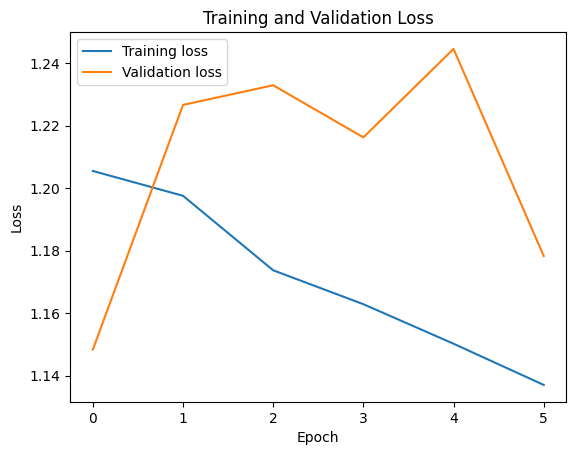

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()